## Consituents and POS tags into a fully connected deep net
In this exploration we generate all the contituents for a set of training tweets then put the count of each one in a vector along with the count of tensed POS tags in a given tweet. We found that the POS tags alone outperform this model, so we decided to drop it and pursue other avenues.

In [3]:
import sys
import pickle
import pandas

from nltk.parse.stanford import StanfordParser

def save_object(arr, filename):
    with open(filename, 'wb') as output:
        pickle.dump(arr, output, pickle.HIGHEST_PROTOCOL)

def add_to_train(constituents, row):
    trainData.append({
        'const': constituents, 
        'row': row,
        'tweet': row.Tweet, 
        'stance': row.Stance, 
        'target': row.Target
    })
    save_object(trainData, "train_0.txt")
    

def get_nodes(parent):
    for node in parent:
        if type(node) is nltk.Tree:
            if node.label() != ROOT:
                if node.label() not in constituentDictionary:
                    constituentDictionary[node.label()] = 1
                else:
                    constituentDictionary[node.label()] = constituentDictionary[node.label()] + 1
                # Keep global track of the constituents
                if node.label() not in globalConstDict:
                    globalConstDict[node.label()] = 1
                else:
                    globalConstDict[node.label()] = globalConstDict[node.label()] + 1
                    
            get_nodes(node)


def create_training_data(input_file, output_file):
    # Change the path according to your system
    stanford_classifier = '/Users/jdeibel/dev/school/nlp/libraries/classifiers/english.all.3class.distsim.crf.ser.gz'
    stanford_ner_path = '/Users/jdeibel/dev/school/nlp/libraries/stanford-ner.jar'

    stanford_parser_dir = '/Users/jdeibel/dev/school/nlp/libraries/'
    eng_model_path = stanford_parser_dir + "edu/stanford/nlp/models/lexparser/englishRNN.ser.gz"
    my_path_to_models_jar = stanford_parser_dir + "models/stanford-english-corenlp-2017-06-09-models.jar"
    my_path_to_jar = stanford_parser_dir + "stanford-parser.jar"

    parser = StanfordParser(model_path=eng_model_path, path_to_models_jar=my_path_to_models_jar, path_to_jar=my_path_to_jar)

    ROOT = 'ROOT'
    constituentDictionary = None
    globalConstDict = {}
    trainData = []
    
    df = pandas.read_csv(input_file, sep='\t', encoding="latin1")
    
    itr = 0
    for item in df.iterrows():
        index, row = item
        parsedTree = list(parser.raw_parse(row.Tweet))
        for tree in parsedTree:
            constituentDictionary = {}
            get_nodes(tree)
            add_to_train(output_file, constituentDictionary, row)
            sys.stdout.write("\r" + str(itr) + " " + str(globalConstDict))
            sys.stdout.flush()
            itr += 1
            
    save_object(globalConstDict, "total_constituents.txt")


In [4]:
import pickle

parsedConstituents = None

with open("train_0.txt", "rb") as f:
    parsedConstituents = pickle.load(f)
import nltk

Constituents = {'VB': 2871, 'PRN': 165, 'PRP': 2912, 'PP': 3802, 
         'QP': 75, 'RBR': 69, 'DT': 3283, 'RRC': 25, 'VBP': 1963, 
         'WRB': 384, 'PDT': 38, 'WHNP': 481, 'WP': 314, 'CD': 763, 
         'SBARQ': 154, "''": 282, 'MD': 771, 'EX': 77, 'NAC': 27, 
         'RP': 180, 'SBAR': 3005, 'CONJP': 8, 'POS': 246, 'FRAG': 1401, 
         '$': 30, 'NNP': 4036, 'VBZ': 1801, 'VP': 10395, 'ADJP': 2027, 
         '-RRB-': 76, '``': 266, 'FW': 75, 'WHADVP': 352, 'UCP': 107, 
         'NN': 9801, 'RBS': 39, 'CC': 1073, 'JJR': 119, 'RB': 2776, 
         'X': 854, '-LRB-': 73, 'UH': 82, 'SQ': 324, 'TO': 1187, 
         'JJ': 4962, 'IN': 4180, 'NP': 19774, 'INTJ': 100, 'S': 6872, 
         'VBG': 964, 'NX': 3, ':': 761, 'VBN': 734, 'JJS': 95, '#': 34, 
         'WHADJP': 22, 'LST': 2, 'ADVP': 1504, 'WHPP': 9, 'SYM': 78, 
         'WDT': 129, 'WP$': 4, '.': 2951, 'NNS': 2695, ',': 1140, 
         'VBD': 634, 'SINV': 279, 'PRT': 178, 'LS': 2, 'PRP$': 798, 
         'NNPS': 70}

TENSED_POS_TAGS = ['POS_VBD', 'POS_VBG', 'POS_VBN', 'POS_VBP', 'POS_VBZ']
XKey = []
YKey = ['AGAINST', 'FAVOR', 'NONE']

# Append the types of constituents and POS tags into our master key array to be used to each
# input row. Each index corresponds to that feature's count and position in our input row of
# our input tensor
for const_key in Constituents:
    XKey.append(const_key)
for pos_key in TENSED_POS_TAGS:
    XKey.append(pos_key)


def get_key_index(key):
    return XKey.index(key)


def constituents_to_features(feature_arr, consts):
    for constituent in consts:
        feature_arr[get_key_index(constituent)] = consts[constituent]
    return feature_arr


def pos_tags_to_features(feature_arr, tweet):
    pos_tags = nltk.pos_tag(nltk.word_tokenize(tweet))
    for tag in pos_tags[1]:
        modified_tag = 'POS_' + tag
        if modified_tag in XKey:
            feature_arr[get_key_index('POS_' + tag)] += 5


def build_features(constituents, tweet):
    feature_arr = []
    for i in range(0, len(XKey)):
        feature_arr.append(0)
    constituents_to_features(feature_arr, constituents)
    pos_tags_to_features(feature_arr, tweet)
    return feature_arr


In [5]:
normal_feature_array = []
normal_label_array = []

for item in parsedConstituents:
    normal_feature_array.append(build_features(item["const"], item["tweet"]))
    normal_label_array.append(YKey.index(item["stance"]))

Train on 1508 samples, validate on 743 samples
Epoch 1/50


  16/1508 [..............................] - ETA: 73s - loss: 14.9719 - acc: 0.3750

 368/1508 [======>.......................] - ETA: 2s - loss: 14.8554 - acc: 0.4321 

 720/1508 [=============>................] - ETA: 0s - loss: 14.6514 - acc: 0.4486

1072/1508 [====================>.........] - ETA: 0s - loss: 14.6863 - acc: 0.4590

1440/1508 [===========================>..] - ETA: 0s - loss: 14.6859 - acc: 0.4722



{'AGAINST': 556, 'FAVOR': 0, 'NONE': 7}


1508/1508 [==============================] - 1s - loss: 14.6504 - acc: 0.4715 - val_loss: 14.5885 - val_acc: 0.4616


Epoch 2/50
  16/1508 [..............................] - ETA: 0s - loss: 15.0302 - acc: 0.3125

 336/1508 [=====>........................] - ETA: 0s - loss: 14.9390 - acc: 0.4524

 704/1508 [=============>................] - ETA: 0s - loss: 14.6466 - acc: 0.4759

1072/1508 [====================>.........] - ETA: 0s - loss: 14.5329 - acc: 0.4739

1424/1508 [===========================>..] - ETA: 0s - loss: 14.4371 - acc: 0.4698



{'AGAINST': 555, 'FAVOR': 0, 'NONE': 8}


1508/1508 [==============================] - 0s - loss: 14.3680 - acc: 0.4702 - val_loss: 14.3058 - val_acc: 0.4616


Epoch 3/50
  16/1508 [..............................] - ETA: 0s - loss: 14.8314 - acc: 0.4375

 352/1508 [======>.......................] - ETA: 0s - loss: 14.2070 - acc: 0.4915

 720/1508 [=============>................] - ETA: 0s - loss: 14.3697 - acc: 0.4861

1088/1508 [====================>.........] - ETA: 0s - loss: 14.1710 - acc: 0.4706

1456/1508 [===========================>..] - ETA: 0s - loss: 14.1174 - acc: 0.4684



{'AGAINST': 554, 'FAVOR': 0, 'NONE': 9}


1508/1508 [==============================] - 0s - loss: 14.0916 - acc: 0.4715 - val_loss: 14.0317 - val_acc: 0.4616


Epoch 4/50
  16/1508 [..............................] - ETA: 0s - loss: 13.3698 - acc: 0.5625

 368/1508 [======>.......................] - ETA: 0s - loss: 13.7056 - acc: 0.4810

 704/1508 [=============>................] - ETA: 0s - loss: 13.8059 - acc: 0.4730

1072/1508 [====================>.........] - ETA: 0s - loss: 13.8762 - acc: 0.4729

1424/1508 [===========================>..] - ETA: 0s - loss: 13.8394 - acc: 0.4705



{'AGAINST': 553, 'FAVOR': 0, 'NONE': 10}


1508/1508 [==============================] - 0s - loss: 13.8209 - acc: 0.4728 - val_loss: 13.7643 - val_acc: 0.4616


Epoch 5/50
  16/1508 [..............................] - ETA: 0s - loss: 14.5219 - acc: 0.3750

 320/1508 [=====>........................] - ETA: 0s - loss: 13.7998 - acc: 0.4719

 688/1508 [============>.................] - ETA: 0s - loss: 13.4518 - acc: 0.4738

1040/1508 [===================>..........] - ETA: 0s - loss: 13.5676 - acc: 0.4740

1408/1508 [===========================>..] - ETA: 0s - loss: 13.5929 - acc: 0.4766



{'AGAINST': 552, 'FAVOR': 0, 'NONE': 11}


1508/1508 [==============================] - 0s - loss: 13.5437 - acc: 0.4755 - val_loss: 13.5037 - val_acc: 0.4590


Epoch 6/50
  16/1508 [..............................] - ETA: 0s - loss: 13.7361 - acc: 0.5625

 352/1508 [======>.......................] - ETA: 0s - loss: 13.4758 - acc: 0.4830

 704/1508 [=============>................] - ETA: 0s - loss: 13.4674 - acc: 0.4716

1072/1508 [====================>.........] - ETA: 0s - loss: 13.4689 - acc: 0.4832

1440/1508 [===========================>..] - ETA: 0s - loss: 13.3542 - acc: 0.4792



{'AGAINST': 552, 'FAVOR': 0, 'NONE': 11}


1508/1508 [==============================] - 0s - loss: 13.2949 - acc: 0.4761 - val_loss: 13.2503 - val_acc: 0.4590


Epoch 7/50
  16/1508 [..............................] - ETA: 0s - loss: 12.4100 - acc: 0.4375

 336/1508 [=====>........................] - ETA: 0s - loss: 13.1496 - acc: 0.4851

 704/1508 [=============>................] - ETA: 0s - loss: 13.1834 - acc: 0.4688

1056/1508 [====================>.........] - ETA: 0s - loss: 13.1902 - acc: 0.4735

1424/1508 [===========================>..] - ETA: 0s - loss: 13.0623 - acc: 0.4796



{'AGAINST': 551, 'FAVOR': 0, 'NONE': 12}


1508/1508 [==============================] - 0s - loss: 13.0436 - acc: 0.4775 - val_loss: 13.0055 - val_acc: 0.4576


Epoch 8/50
  16/1508 [..............................] - ETA: 0s - loss: 13.5899 - acc: 0.5000

 336/1508 [=====>........................] - ETA: 0s - loss: 12.7555 - acc: 0.4970

 688/1508 [============>.................] - ETA: 0s - loss: 12.9138 - acc: 0.4869

1024/1508 [===================>..........] - ETA: 0s - loss: 12.9555 - acc: 0.4824

1392/1508 [==========================>...] - ETA: 0s - loss: 12.8624 - acc: 0.4806



{'AGAINST': 551, 'FAVOR': 0, 'NONE': 12}


1508/1508 [==============================] - 0s - loss: 12.8091 - acc: 0.4781 - val_loss: 12.7667 - val_acc: 0.4576


Epoch 9/50
  16/1508 [..............................] - ETA: 0s - loss: 13.1405 - acc: 0.5625

 368/1508 [======>.......................] - ETA: 0s - loss: 12.9164 - acc: 0.5082

 720/1508 [=============>................] - ETA: 0s - loss: 12.7245 - acc: 0.5056

1088/1508 [====================>.........] - ETA: 0s - loss: 12.6496 - acc: 0.4954

1456/1508 [===========================>..] - ETA: 0s - loss: 12.6038 - acc: 0.4815


{'AGAINST': 550, 'FAVOR': 0, 'NONE': 13}


1508/1508 [==============================] - 0s - loss: 12.5760 - acc: 0.4794 - val_loss: 12.5348 - val_acc: 0.4549


Epoch 10/50
  16/1508 [..............................] - ETA: 0s - loss: 12.2115 - acc: 0.4375

 352/1508 [======>.......................] - ETA: 0s - loss: 12.5315 - acc: 0.4858

 720/1508 [=============>................] - ETA: 0s - loss: 12.3764 - acc: 0.4958

1072/1508 [====================>.........] - ETA: 0s - loss: 12.4359 - acc: 0.4841

1440/1508 [===========================>..] - ETA: 0s - loss: 12.3792 - acc: 0.4819



{'AGAINST': 549, 'FAVOR': 0, 'NONE': 14}


1508/1508 [==============================] - 0s - loss: 12.3436 - acc: 0.4794 - val_loss: 12.3087 - val_acc: 0.4563


Epoch 11/50
  16/1508 [..............................] - ETA: 0s - loss: 10.8935 - acc: 0.5625

 368/1508 [======>.......................] - ETA: 0s - loss: 12.2801 - acc: 0.4837

 720/1508 [=============>................] - ETA: 0s - loss: 12.1535 - acc: 0.4764

1088/1508 [====================>.........] - ETA: 0s - loss: 12.1628 - acc: 0.4688

1456/1508 [===========================>..] - ETA: 0s - loss: 12.1322 - acc: 0.4794



{'AGAINST': 548, 'FAVOR': 0, 'NONE': 15}


1508/1508 [==============================] - 0s - loss: 12.1193 - acc: 0.4788 - val_loss: 12.0911 - val_acc: 0.4563


Epoch 12/50
  16/1508 [..............................] - ETA: 0s - loss: 12.3461 - acc: 0.6250

 352/1508 [======>.......................] - ETA: 0s - loss: 12.0828 - acc: 0.4744

 704/1508 [=============>................] - ETA: 0s - loss: 12.0323 - acc: 0.4858

1072/1508 [====================>.........] - ETA: 0s - loss: 11.9572 - acc: 0.4776

1424/1508 [===========================>..] - ETA: 0s - loss: 11.9495 - acc: 0.4824



{'AGAINST': 545, 'FAVOR': 0, 'NONE': 18}


1508/1508 [==============================] - 0s - loss: 11.9103 - acc: 0.4801 - val_loss: 11.8785 - val_acc: 0.4563


Epoch 13/50
  16/1508 [..............................] - ETA: 0s - loss: 11.6552 - acc: 0.4375

 352/1508 [======>.......................] - ETA: 0s - loss: 11.7124 - acc: 0.4688

 720/1508 [=============>................] - ETA: 0s - loss: 11.6947 - acc: 0.4583

1088/1508 [====================>.........] - ETA: 0s - loss: 11.6678 - acc: 0.4678

1440/1508 [===========================>..] - ETA: 0s - loss: 11.7035 - acc: 0.4771



{'AGAINST': 544, 'FAVOR': 0, 'NONE': 19}


1508/1508 [==============================] - 0s - loss: 11.6963 - acc: 0.4788 - val_loss: 11.6743 - val_acc: 0.4576


Epoch 14/50
  16/1508 [..............................] - ETA: 0s - loss: 10.7808 - acc: 0.3750

 352/1508 [======>.......................] - ETA: 0s - loss: 11.4356 - acc: 0.4602

 704/1508 [=============>................] - ETA: 0s - loss: 11.5730 - acc: 0.4588

1072/1508 [====================>.........] - ETA: 0s - loss: 11.5950 - acc: 0.4785

1440/1508 [===========================>..] - ETA: 0s - loss: 11.5266 - acc: 0.4764



{'AGAINST': 543, 'FAVOR': 0, 'NONE': 20}


1508/1508 [==============================] - 0s - loss: 11.5041 - acc: 0.4794 - val_loss: 11.4748 - val_acc: 0.4576


Epoch 15/50
  16/1508 [..............................] - ETA: 0s - loss: 11.2834 - acc: 0.3750

 336/1508 [=====>........................] - ETA: 0s - loss: 11.6172 - acc: 0.4702

 688/1508 [============>.................] - ETA: 0s - loss: 11.5357 - acc: 0.4666

1056/1508 [====================>.........] - ETA: 0s - loss: 11.4199 - acc: 0.4792

1392/1508 [==========================>...] - ETA: 0s - loss: 11.3300 - acc: 0.4777



{'AGAINST': 542, 'FAVOR': 0, 'NONE': 21}


1508/1508 [==============================] - 0s - loss: 11.2998 - acc: 0.4794 - val_loss: 11.2824 - val_acc: 0.4563


Epoch 16/50
  16/1508 [..............................] - ETA: 0s - loss: 10.8438 - acc: 0.6875

 352/1508 [======>.......................] - ETA: 0s - loss: 11.3072 - acc: 0.4659

 720/1508 [=============>................] - ETA: 0s - loss: 11.2367 - acc: 0.4875

1072/1508 [====================>.........] - ETA: 0s - loss: 11.1866 - acc: 0.4813

1440/1508 [===========================>..] - ETA: 0s - loss: 11.1539 - acc: 0.4792



{'AGAINST': 540, 'FAVOR': 0, 'NONE': 23}


1508/1508 [==============================] - 0s - loss: 11.1145 - acc: 0.4781 - val_loss: 11.0957 - val_acc: 0.4563


Epoch 17/50
  16/1508 [..............................] - ETA: 0s - loss: 12.1710 - acc: 0.2500

 368/1508 [======>.......................] - ETA: 0s - loss: 10.9274 - acc: 0.4783

 720/1508 [=============>................] - ETA: 0s - loss: 10.9131 - acc: 0.4750

1072/1508 [====================>.........] - ETA: 0s - loss: 10.9286 - acc: 0.4757

1408/1508 [===========================>..] - ETA: 0s - loss: 10.9501 - acc: 0.4723



{'AGAINST': 540, 'FAVOR': 0, 'NONE': 23}


1508/1508 [==============================] - 0s - loss: 10.9345 - acc: 0.4768 - val_loss: 10.9164 - val_acc: 0.4576


Epoch 18/50
  16/1508 [..............................] - ETA: 0s - loss: 12.2148 - acc: 0.2500

 368/1508 [======>.......................] - ETA: 0s - loss: 11.0332 - acc: 0.4701

 720/1508 [=============>................] - ETA: 0s - loss: 10.8114 - acc: 0.4708

1088/1508 [====================>.........] - ETA: 0s - loss: 10.8107 - acc: 0.4715

1440/1508 [===========================>..] - ETA: 0s - loss: 10.7584 - acc: 0.4757



{'AGAINST': 539, 'FAVOR': 0, 'NONE': 24}


1508/1508 [==============================] - 0s - loss: 10.7565 - acc: 0.4761 - val_loss: 10.7430 - val_acc: 0.4576


Epoch 19/50
  16/1508 [..............................] - ETA: 0s - loss: 10.7749 - acc: 0.5625

 352/1508 [======>.......................] - ETA: 0s - loss: 10.6291 - acc: 0.5000

 704/1508 [=============>................] - ETA: 0s - loss: 10.6403 - acc: 0.4858

1056/1508 [====================>.........] - ETA: 0s - loss: 10.6272 - acc: 0.4621

1424/1508 [===========================>..] - ETA: 0s - loss: 10.6193 - acc: 0.4726



{'AGAINST': 539, 'FAVOR': 0, 'NONE': 24}


1508/1508 [==============================] - 0s - loss: 10.5886 - acc: 0.4755 - val_loss: 10.5755 - val_acc: 0.4590


Epoch 20/50
  16/1508 [..............................] - ETA: 0s - loss: 11.1483 - acc: 0.5000

 352/1508 [======>.......................] - ETA: 0s - loss: 10.4629 - acc: 0.4858

 704/1508 [=============>................] - ETA: 0s - loss: 10.5220 - acc: 0.4844

1008/1508 [===================>..........] - ETA: 0s - loss: 10.4894 - acc: 0.4841

1360/1508 [==========================>...] - ETA: 0s - loss: 10.4797 - acc: 0.4801



{'AGAINST': 539, 'FAVOR': 0, 'NONE': 24}


1508/1508 [==============================] - 0s - loss: 10.4250 - acc: 0.4748 - val_loss: 10.4140 - val_acc: 0.4603


Epoch 21/50
  16/1508 [..............................] - ETA: 0s - loss: 9.3162 - acc: 0.5625

 352/1508 [======>.......................] - ETA: 0s - loss: 10.1693 - acc: 0.5142

 704/1508 [=============>................] - ETA: 0s - loss: 10.1719 - acc: 0.4830

1056/1508 [====================>.........] - ETA: 0s - loss: 10.2384 - acc: 0.4735

1408/1508 [===========================>..] - ETA: 0s - loss: 10.2914 - acc: 0.4737



{'AGAINST': 539, 'FAVOR': 0, 'NONE': 24}


1508/1508 [==============================] - 0s - loss: 10.2640 - acc: 0.4741 - val_loss: 10.2588 - val_acc: 0.4603


Epoch 22/50
  16/1508 [..............................] - ETA: 0s - loss: 10.0497 - acc: 0.4375

 336/1508 [=====>........................] - ETA: 0s - loss: 10.1770 - acc: 0.4554

 704/1508 [=============>................] - ETA: 0s - loss: 10.2133 - acc: 0.4474

1056/1508 [====================>.........] - ETA: 0s - loss: 10.1461 - acc: 0.4593

1424/1508 [===========================>..] - ETA: 0s - loss: 10.1364 - acc: 0.4775



{'AGAINST': 540, 'FAVOR': 0, 'NONE': 23}


1508/1508 [==============================] - 0s - loss: 10.1139 - acc: 0.4741 - val_loss: 10.1094 - val_acc: 0.4603


Epoch 23/50
  16/1508 [..............................] - ETA: 0s - loss: 9.8629 - acc: 0.6250

 368/1508 [======>.......................] - ETA: 0s - loss: 10.0602 - acc: 0.4565

 704/1508 [=============>................] - ETA: 0s - loss: 10.0602 - acc: 0.4773

1072/1508 [====================>.........] - ETA: 0s - loss: 10.0688 - acc: 0.4795

1440/1508 [===========================>..] - ETA: 0s - loss: 9.9818 - acc: 0.4722 



{'AGAINST': 539, 'FAVOR': 0, 'NONE': 24}


1508/1508 [==============================] - 0s - loss: 9.9653 - acc: 0.4735 - val_loss: 9.9646 - val_acc: 0.4630


Epoch 24/50
  16/1508 [..............................] - ETA: 0s - loss: 10.9534 - acc: 0.5000

 336/1508 [=====>........................] - ETA: 0s - loss: 9.9701 - acc: 0.5030 

 688/1508 [============>.................] - ETA: 0s - loss: 9.9737 - acc: 0.4942

1040/1508 [===================>..........] - ETA: 0s - loss: 9.8724 - acc: 0.4894

1408/1508 [===========================>..] - ETA: 0s - loss: 9.8180 - acc: 0.4773



{'AGAINST': 540, 'FAVOR': 0, 'NONE': 23}


1508/1508 [==============================] - 0s - loss: 9.8185 - acc: 0.4735 - val_loss: 9.8262 - val_acc: 0.4603


Epoch 25/50
  16/1508 [..............................] - ETA: 0s - loss: 10.1194 - acc: 0.5625

 352/1508 [======>.......................] - ETA: 0s - loss: 9.7360 - acc: 0.4460 

 704/1508 [=============>................] - ETA: 0s - loss: 9.6912 - acc: 0.4347

1056/1508 [====================>.........] - ETA: 0s - loss: 9.6950 - acc: 0.4536

1408/1508 [===========================>..] - ETA: 0s - loss: 9.7215 - acc: 0.4702



{'AGAINST': 540, 'FAVOR': 0, 'NONE': 23}


1508/1508 [==============================] - 0s - loss: 9.6853 - acc: 0.4728 - val_loss: 9.6922 - val_acc: 0.4603


Epoch 26/50
  16/1508 [..............................] - ETA: 0s - loss: 8.4704 - acc: 0.3125

 336/1508 [=====>........................] - ETA: 0s - loss: 9.6449 - acc: 0.4583

 688/1508 [============>.................] - ETA: 0s - loss: 9.6784 - acc: 0.4608

1040/1508 [===================>..........] - ETA: 0s - loss: 9.6396 - acc: 0.4750

1392/1508 [==========================>...] - ETA: 0s - loss: 9.5600 - acc: 0.4749



{'AGAINST': 539, 'FAVOR': 0, 'NONE': 24}


1508/1508 [==============================] - 0s - loss: 9.5533 - acc: 0.4715 - val_loss: 9.5632 - val_acc: 0.4643


Epoch 27/50
  16/1508 [..............................] - ETA: 0s - loss: 8.7259 - acc: 0.3125

 336/1508 [=====>........................] - ETA: 0s - loss: 9.5126 - acc: 0.4762

 704/1508 [=============>................] - ETA: 0s - loss: 9.5973 - acc: 0.4787

1056/1508 [====================>.........] - ETA: 0s - loss: 9.5077 - acc: 0.4725

1392/1508 [==========================>...] - ETA: 0s - loss: 9.4419 - acc: 0.4705



{'AGAINST': 539, 'FAVOR': 0, 'NONE': 24}


1508/1508 [==============================] - 0s - loss: 9.4236 - acc: 0.4715 - val_loss: 9.4390 - val_acc: 0.4657


Epoch 28/50
  16/1508 [..............................] - ETA: 0s - loss: 9.7364 - acc: 0.4375

 352/1508 [======>.......................] - ETA: 0s - loss: 9.4036 - acc: 0.4688

 704/1508 [=============>................] - ETA: 0s - loss: 9.3546 - acc: 0.4716

1072/1508 [====================>.........] - ETA: 0s - loss: 9.2987 - acc: 0.4739

1424/1508 [===========================>..] - ETA: 0s - loss: 9.3204 - acc: 0.4740



{'AGAINST': 540, 'FAVOR': 0, 'NONE': 23}


1508/1508 [==============================] - 0s - loss: 9.3013 - acc: 0.4715 - val_loss: 9.3197 - val_acc: 0.4657


Epoch 29/50
  16/1508 [..............................] - ETA: 0s - loss: 8.7261 - acc: 0.5000

 336/1508 [=====>........................] - ETA: 0s - loss: 9.1912 - acc: 0.4345

 688/1508 [============>.................] - ETA: 0s - loss: 9.1153 - acc: 0.4637

1040/1508 [===================>..........] - ETA: 0s - loss: 9.2097 - acc: 0.4577

1392/1508 [==========================>...] - ETA: 0s - loss: 9.1720 - acc: 0.4698



{'AGAINST': 542, 'FAVOR': 0, 'NONE': 21}


1508/1508 [==============================] - 0s - loss: 9.1800 - acc: 0.4721 - val_loss: 9.2052 - val_acc: 0.4630


Epoch 30/50
  16/1508 [..............................] - ETA: 0s - loss: 9.5815 - acc: 0.4375

 352/1508 [======>.......................] - ETA: 0s - loss: 9.0559 - acc: 0.4773

 704/1508 [=============>................] - ETA: 0s - loss: 9.0301 - acc: 0.4759

1072/1508 [====================>.........] - ETA: 0s - loss: 9.0457 - acc: 0.4683

1440/1508 [===========================>..] - ETA: 0s - loss: 9.0757 - acc: 0.4674



{'AGAINST': 544, 'FAVOR': 0, 'NONE': 19}


1508/1508 [==============================] - 0s - loss: 9.0692 - acc: 0.4721 - val_loss: 9.0945 - val_acc: 0.4616


Epoch 31/50
  16/1508 [..............................] - ETA: 0s - loss: 8.2513 - acc: 0.5625

 352/1508 [======>.......................] - ETA: 0s - loss: 9.1121 - acc: 0.4574

 704/1508 [=============>................] - ETA: 0s - loss: 9.1337 - acc: 0.4716

1056/1508 [====================>.........] - ETA: 0s - loss: 9.0507 - acc: 0.4593

1408/1508 [===========================>..] - ETA: 0s - loss: 9.0110 - acc: 0.4695



{'AGAINST': 545, 'FAVOR': 0, 'NONE': 18}


1508/1508 [==============================] - 0s - loss: 8.9653 - acc: 0.4715 - val_loss: 8.9881 - val_acc: 0.4603


Epoch 32/50
  16/1508 [..............................] - ETA: 0s - loss: 9.2182 - acc: 0.5000

 352/1508 [======>.......................] - ETA: 0s - loss: 9.0040 - acc: 0.5085

 704/1508 [=============>................] - ETA: 0s - loss: 8.9499 - acc: 0.5014

1072/1508 [====================>.........] - ETA: 0s - loss: 8.8986 - acc: 0.4813

1440/1508 [===========================>..] - ETA: 0s - loss: 8.8604 - acc: 0.4750



{'AGAINST': 545, 'FAVOR': 0, 'NONE': 18}


1508/1508 [==============================] - 0s - loss: 8.8589 - acc: 0.4708 - val_loss: 8.8866 - val_acc: 0.4616


Epoch 33/50
  16/1508 [..............................] - ETA: 0s - loss: 9.6422 - acc: 0.5000

 352/1508 [======>.......................] - ETA: 0s - loss: 8.8958 - acc: 0.4517

 720/1508 [=============>................] - ETA: 0s - loss: 8.8275 - acc: 0.4708

1072/1508 [====================>.........] - ETA: 0s - loss: 8.7755 - acc: 0.4692

1424/1508 [===========================>..] - ETA: 0s - loss: 8.7633 - acc: 0.4719



{'AGAINST': 545, 'FAVOR': 0, 'NONE': 18}


1508/1508 [==============================] - 0s - loss: 8.7596 - acc: 0.4702 - val_loss: 8.7891 - val_acc: 0.4603


Epoch 34/50
  16/1508 [..............................] - ETA: 0s - loss: 8.6699 - acc: 0.3125

 352/1508 [======>.......................] - ETA: 0s - loss: 8.8339 - acc: 0.4091

 704/1508 [=============>................] - ETA: 0s - loss: 8.7993 - acc: 0.4588

1056/1508 [====================>.........] - ETA: 0s - loss: 8.7194 - acc: 0.4735

1392/1508 [==========================>...] - ETA: 0s - loss: 8.7043 - acc: 0.4720



{'AGAINST': 546, 'FAVOR': 0, 'NONE': 17}


1508/1508 [==============================] - 0s - loss: 8.6657 - acc: 0.4702 - val_loss: 8.6954 - val_acc: 0.4603


Epoch 35/50
  16/1508 [..............................] - ETA: 0s - loss: 9.3586 - acc: 0.3750

 336/1508 [=====>........................] - ETA: 0s - loss: 8.3986 - acc: 0.4911

 704/1508 [=============>................] - ETA: 0s - loss: 8.4845 - acc: 0.4787

1072/1508 [====================>.........] - ETA: 0s - loss: 8.5334 - acc: 0.4674

1424/1508 [===========================>..] - ETA: 0s - loss: 8.6010 - acc: 0.4719



{'AGAINST': 546, 'FAVOR': 0, 'NONE': 17}


1508/1508 [==============================] - 0s - loss: 8.5735 - acc: 0.4702 - val_loss: 8.6054 - val_acc: 0.4603


Epoch 36/50
  16/1508 [..............................] - ETA: 0s - loss: 8.5099 - acc: 0.6250

 352/1508 [======>.......................] - ETA: 0s - loss: 8.4976 - acc: 0.4972

 704/1508 [=============>................] - ETA: 0s - loss: 8.4875 - acc: 0.4830

1056/1508 [====================>.........] - ETA: 0s - loss: 8.5081 - acc: 0.4763

1408/1508 [===========================>..] - ETA: 0s - loss: 8.5017 - acc: 0.4716



{'AGAINST': 546, 'FAVOR': 0, 'NONE': 17}


1508/1508 [==============================] - 0s - loss: 8.4814 - acc: 0.4708 - val_loss: 8.5181 - val_acc: 0.4616


Epoch 37/50
  16/1508 [..............................] - ETA: 0s - loss: 8.6478 - acc: 0.2500

 336/1508 [=====>........................] - ETA: 0s - loss: 8.4922 - acc: 0.4762

 688/1508 [============>.................] - ETA: 0s - loss: 8.4207 - acc: 0.4869

1040/1508 [===================>..........] - ETA: 0s - loss: 8.4123 - acc: 0.4788

1408/1508 [===========================>..] - ETA: 0s - loss: 8.4156 - acc: 0.4730



{'AGAINST': 548, 'FAVOR': 0, 'NONE': 15}


1508/1508 [==============================] - 0s - loss: 8.3968 - acc: 0.4715 - val_loss: 8.4341 - val_acc: 0.4616


Epoch 38/50
  16/1508 [..............................] - ETA: 0s - loss: 8.0043 - acc: 0.3125

 352/1508 [======>.......................] - ETA: 0s - loss: 8.4722 - acc: 0.4233

 704/1508 [=============>................] - ETA: 0s - loss: 8.3539 - acc: 0.4545

1072/1508 [====================>.........] - ETA: 0s - loss: 8.3580 - acc: 0.4720

1408/1508 [===========================>..] - ETA: 0s - loss: 8.3180 - acc: 0.4702



{'AGAINST': 548, 'FAVOR': 0, 'NONE': 15}


1508/1508 [==============================] - 0s - loss: 8.3155 - acc: 0.4728 - val_loss: 8.3535 - val_acc: 0.4616


Epoch 39/50
  16/1508 [..............................] - ETA: 0s - loss: 8.7181 - acc: 0.5625

 352/1508 [======>.......................] - ETA: 0s - loss: 8.4345 - acc: 0.5057

 704/1508 [=============>................] - ETA: 0s - loss: 8.3613 - acc: 0.4716

1056/1508 [====================>.........] - ETA: 0s - loss: 8.2979 - acc: 0.4640

1424/1508 [===========================>..] - ETA: 0s - loss: 8.2582 - acc: 0.4705



{'AGAINST': 548, 'FAVOR': 0, 'NONE': 15}


1508/1508 [==============================] - 0s - loss: 8.2377 - acc: 0.4702 - val_loss: 8.2755 - val_acc: 0.4616


Epoch 40/50
  16/1508 [..............................] - ETA: 0s - loss: 8.4738 - acc: 0.5625

 368/1508 [======>.......................] - ETA: 0s - loss: 8.2332 - acc: 0.4484

 720/1508 [=============>................] - ETA: 0s - loss: 8.1742 - acc: 0.4542

1088/1508 [====================>.........] - ETA: 0s - loss: 8.1729 - acc: 0.4715

1440/1508 [===========================>..] - ETA: 0s - loss: 8.1798 - acc: 0.4694



{'AGAINST': 550, 'FAVOR': 0, 'NONE': 13}


1508/1508 [==============================] - 0s - loss: 8.1590 - acc: 0.4702 - val_loss: 8.2005 - val_acc: 0.4603


Epoch 41/50
  16/1508 [..............................] - ETA: 0s - loss: 8.6807 - acc: 0.5625

 336/1508 [=====>........................] - ETA: 0s - loss: 8.1051 - acc: 0.5179

 688/1508 [============>.................] - ETA: 0s - loss: 8.1607 - acc: 0.4840

1040/1508 [===================>..........] - ETA: 0s - loss: 8.1463 - acc: 0.4808

1392/1508 [==========================>...] - ETA: 0s - loss: 8.1073 - acc: 0.4727



{'AGAINST': 551, 'FAVOR': 0, 'NONE': 12}


1508/1508 [==============================] - 0s - loss: 8.0827 - acc: 0.4688 - val_loss: 8.1286 - val_acc: 0.4603


Epoch 42/50
  16/1508 [..............................] - ETA: 0s - loss: 8.2145 - acc: 0.3125

 320/1508 [=====>........................] - ETA: 0s - loss: 8.0033 - acc: 0.4656

 672/1508 [============>.................] - ETA: 0s - loss: 8.1181 - acc: 0.4494

1024/1508 [===================>..........] - ETA: 0s - loss: 8.0790 - acc: 0.4590

1392/1508 [==========================>...] - ETA: 0s - loss: 8.0272 - acc: 0.4713



{'AGAINST': 551, 'FAVOR': 0, 'NONE': 12}


1508/1508 [==============================] - 0s - loss: 8.0143 - acc: 0.4675 - val_loss: 8.0591 - val_acc: 0.4616


Epoch 43/50
  16/1508 [..............................] - ETA: 0s - loss: 7.4997 - acc: 0.5000

 336/1508 [=====>........................] - ETA: 0s - loss: 7.7629 - acc: 0.4643

 688/1508 [============>.................] - ETA: 0s - loss: 7.9471 - acc: 0.4709

1056/1508 [====================>.........] - ETA: 0s - loss: 7.9258 - acc: 0.4697

1408/1508 [===========================>..] - ETA: 0s - loss: 7.9577 - acc: 0.4716



{'AGAINST': 551, 'FAVOR': 0, 'NONE': 12}


1508/1508 [==============================] - 0s - loss: 7.9499 - acc: 0.4682 - val_loss: 7.9925 - val_acc: 0.4616


Epoch 44/50
  16/1508 [..............................] - ETA: 0s - loss: 7.1599 - acc: 0.4375

 352/1508 [======>.......................] - ETA: 0s - loss: 7.9231 - acc: 0.4517

 688/1508 [============>.................] - ETA: 0s - loss: 7.9830 - acc: 0.4448

1024/1508 [===================>..........] - ETA: 0s - loss: 7.9413 - acc: 0.4590

1392/1508 [==========================>...] - ETA: 0s - loss: 7.9197 - acc: 0.4677



{'AGAINST': 551, 'FAVOR': 0, 'NONE': 12}


1508/1508 [==============================] - 0s - loss: 7.8820 - acc: 0.4668 - val_loss: 7.9279 - val_acc: 0.4616


Epoch 45/50
  16/1508 [..............................] - ETA: 0s - loss: 7.9664 - acc: 0.3750

 352/1508 [======>.......................] - ETA: 0s - loss: 8.0054 - acc: 0.4886

 688/1508 [============>.................] - ETA: 0s - loss: 7.8560 - acc: 0.4593

1040/1508 [===================>..........] - ETA: 0s - loss: 7.8537 - acc: 0.4635

1392/1508 [==========================>...] - ETA: 0s - loss: 7.8458 - acc: 0.4691



{'AGAINST': 552, 'FAVOR': 0, 'NONE': 11}


1508/1508 [==============================] - 0s - loss: 7.8200 - acc: 0.4675 - val_loss: 7.8659 - val_acc: 0.4616


Epoch 46/50
  16/1508 [..............................] - ETA: 0s - loss: 7.6273 - acc: 0.6250

 352/1508 [======>.......................] - ETA: 0s - loss: 7.8401 - acc: 0.4602

 688/1508 [============>.................] - ETA: 0s - loss: 7.7584 - acc: 0.4738

1040/1508 [===================>..........] - ETA: 0s - loss: 7.8041 - acc: 0.4721

1392/1508 [==========================>...] - ETA: 0s - loss: 7.7742 - acc: 0.4741



{'AGAINST': 554, 'FAVOR': 0, 'NONE': 9}


1508/1508 [==============================] - 0s - loss: 7.7558 - acc: 0.4682 - val_loss: 7.8056 - val_acc: 0.4616


Epoch 47/50
  16/1508 [..............................] - ETA: 0s - loss: 7.7733 - acc: 0.4375

 352/1508 [======>.......................] - ETA: 0s - loss: 7.7928 - acc: 0.5114

 688/1508 [============>.................] - ETA: 0s - loss: 7.6716 - acc: 0.4724

1040/1508 [===================>..........] - ETA: 0s - loss: 7.6801 - acc: 0.4654

1408/1508 [===========================>..] - ETA: 0s - loss: 7.6894 - acc: 0.4695



{'AGAINST': 554, 'FAVOR': 0, 'NONE': 9}


1508/1508 [==============================] - 0s - loss: 7.6988 - acc: 0.4688 - val_loss: 7.7477 - val_acc: 0.4630


Epoch 48/50
  16/1508 [..............................] - ETA: 0s - loss: 7.4620 - acc: 0.3750

 336/1508 [=====>........................] - ETA: 0s - loss: 7.7367 - acc: 0.4435

 672/1508 [============>.................] - ETA: 0s - loss: 7.6826 - acc: 0.4435

1024/1508 [===================>..........] - ETA: 0s - loss: 7.6459 - acc: 0.4678

1376/1508 [==========================>...] - ETA: 0s - loss: 7.6493 - acc: 0.4731



{'AGAINST': 554, 'FAVOR': 0, 'NONE': 9}


1508/1508 [==============================] - 0s - loss: 7.6389 - acc: 0.4682 - val_loss: 7.6910 - val_acc: 0.4616


Epoch 49/50
  16/1508 [..............................] - ETA: 0s - loss: 7.3700 - acc: 0.3750

 352/1508 [======>.......................] - ETA: 0s - loss: 7.6934 - acc: 0.4943

 688/1508 [============>.................] - ETA: 0s - loss: 7.6424 - acc: 0.4709

1040/1508 [===================>..........] - ETA: 0s - loss: 7.6085 - acc: 0.4731

1376/1508 [==========================>...] - ETA: 0s - loss: 7.6125 - acc: 0.4637



{'AGAINST': 554, 'FAVOR': 0, 'NONE': 9}


1508/1508 [==============================] - 0s - loss: 7.5867 - acc: 0.4688 - val_loss: 7.6367 - val_acc: 0.4616


Epoch 50/50
  16/1508 [..............................] - ETA: 0s - loss: 7.2771 - acc: 0.4375

 256/1508 [====>.........................] - ETA: 0s - loss: 7.6618 - acc: 0.4531

 576/1508 [==========>...................] - ETA: 0s - loss: 7.5850 - acc: 0.4670

 928/1508 [=================>............] - ETA: 0s - loss: 7.5638 - acc: 0.4709

1296/1508 [========================>.....] - ETA: 0s - loss: 7.5358 - acc: 0.4691



{'AGAINST': 554, 'FAVOR': 0, 'NONE': 9}


1508/1508 [==============================] - 0s - loss: 7.5303 - acc: 0.4688 - val_loss: 7.5843 - val_acc: 0.4616

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


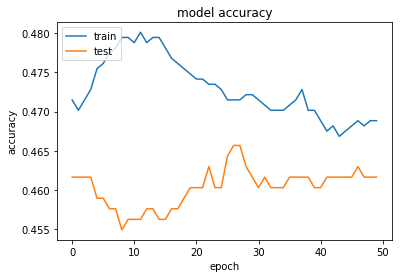

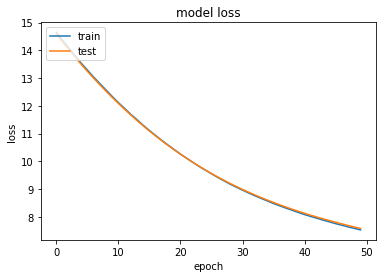

 32/563 [>.............................] - ETA: 0s

[13.810788376504956, 0.52042628811477132]


In [20]:
import numpy as np
import keras

from keras.utils import to_categorical
from keras.models import Sequential
from keras.callbacks import Callback
from keras.layers import Dense, Activation, Dropout
# To split data stuff
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import regularizers

class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.STANCES = ['AGAINST', 'FAVOR', 'NONE']

    def on_epoch_end(self, epoch, logs={}):
        preds = self.model.predict(self.test_data, verbose=0)
        count = {'AGAINST': 0, 'FAVOR': 0, 'NONE': 0}
        for prediction in preds:
            count[self.STANCES[prediction.tolist().index(max(prediction))]] += 1
        print('\n')
        print(count)
        print('\n')

OUTPUT = 3

np_feat_arr = np.array(normal_feature_array)
np_label_arr = to_categorical(normal_label_array, OUTPUT)

# Do a split
X_train, X_test, y_train, y_test = train_test_split(np_feat_arr, 
                                                    np_label_arr, 
                                                    test_size=0.2, 
                                                    random_state=46)

model = Sequential()
model.add(Dense(units=len(XKey), 
                input_dim=len(XKey),
                activity_regularizer=regularizers.l1(0.01)))
model.add(Activation('relu'))
model.add(Dense(units=16))
model.add(Activation('relu'))
model.add(Dense(units=64))
model.add(Activation('relu'))
model.add(Dense(units=12))
model.add(Activation('relu'))
model.add(Dense(units=OUTPUT))
model.add(Activation('softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.00001),
              metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train, validation_split=0.33, 
                    epochs=50, batch_size=16, verbose=1, callbacks=[TestCallback(X_test)])
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

loss_and_metrics = model.evaluate(X_test, y_test, batch_size=32)

print(loss_and_metrics)
